In [1]:
from fealpy.pde.truss_model import Truss2DFourBar

from fealpy.functionspace import LagrangeFESpace

from fealpy.fem import BilinearForm
from fealpy.fem import TrussStructureIntegrator
from fealpy.fem import DirichletBC

from scipy.sparse.linalg import spsolve

import matplotlib.pyplot as plt
import numpy as np

node:
 [[  0.   0.]
 [400.   0.]
 [400. 300.]
 [  0. 300.]]
NN: 4
cell:
 [[0 1]
 [2 1]
 [0 2]
 [3 2]]
NC: 4


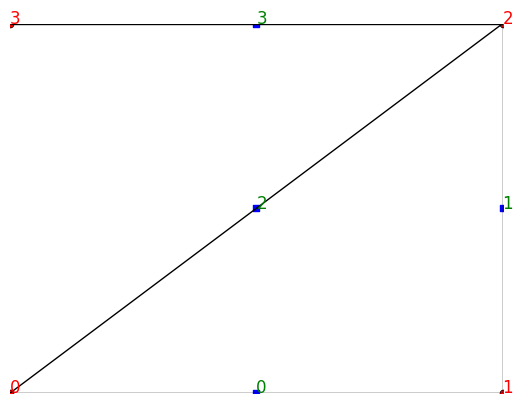

In [2]:
pde = Truss2DFourBar()

mesh = pde.init_mesh()
node = mesh.entity('node')
NN = mesh.number_of_nodes()
cell = mesh.entity('cell') 
NC = mesh.number_of_cells()
print("node:\n", node)
print("NN:", NN)
print("cell:\n", cell)
print("NC:", NC)

fig = plt.figure()
axes = fig.gca()
mesh.add_plot(axes)
mesh.find_node(axes, showindex=True, fontsize=12, fontcolor='r')
mesh.find_cell(axes, showindex=True, fontsize=12, fontcolor='g')
plt.show()

In [3]:
GD = mesh.geo_dimension()
print("GD:", GD)

space = LagrangeFESpace(mesh, p=1, spacetype='C', doforder='vdims')

gdof = space.number_of_global_dofs() 
ldof = space.number_of_local_dofs()
print("gdof:", gdof)
print("ldof:", ldof)

GD: 2
gdof: 4
ldof: 2


In [4]:
vspace = GD*(space, ) # 把标量空间张成向量空间
print("space:", vspace)

uh = vspace[0].function(dim=GD) 
print("uh:(gdof, GD)\n", uh)
print(uh.shape)

bform = BilinearForm(vspace)
print("bform:", bform)

space: (<fealpy.functionspace.lagrange_fe_space.LagrangeFESpace object at 0x7f4a62e8c580>, <fealpy.functionspace.lagrange_fe_space.LagrangeFESpace object at 0x7f4a62e8c580>)
uh:(gdof, GD)
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
(4, 2)
bform: <fealpy.fem.bilinear_form.BilinearForm object at 0x7f4a62e8ecb0>


In [5]:
E0 = pde.E # 杨氏模量
A0 = pde.A # 横截面积
# print("全局坐标系下的单元刚度矩阵 k, (NC, GD*ldof, GD*ldof):", 
#       TrussStructureIntegrator(E0, A0).assembly_cell_matrix(vspace).shape)
print("全局坐标系下的四个单元刚度矩阵 k1,k2,k3,k4 如下\n:", 
      TrussStructureIntegrator(E0, A0).assembly_cell_matrix(vspace))

全局坐标系下的四个单元刚度矩阵 k1,k2,k3,k4 如下
: [[[ 73750.              0.         -73750.              0.        ]
  [     0.              0.              0.              0.        ]
  [-73750.              0.          73750.              0.        ]
  [     0.              0.              0.              0.        ]]

 [[     0.              0.              0.              0.        ]
  [     0.          98333.33333333      0.         -98333.33333333]
  [     0.              0.              0.              0.        ]
  [     0.         -98333.33333333      0.          98333.33333333]]

 [[ 37760.          28320.         -37760.         -28320.        ]
  [ 28320.          21240.         -28320.         -21240.        ]
  [-37760.         -28320.          37760.          28320.        ]
  [-28320.         -21240.          28320.          21240.        ]]

 [[ 73750.              0.         -73750.              0.        ]
  [     0.              0.              0.              0.        ]
  [-73750

In [6]:
bform.add_domain_integrator(TrussStructureIntegrator(E0, A0))
K = bform.assembly() # 基函数由标量函数组合而成的向量函数空间

print("全局刚度矩阵 KK(GD*gdof, GD*gdof):\n", K.toarray())

全局刚度矩阵 KK(GD*gdof, GD*gdof):
 [[111510.          28320.         -73750.              0.
  -37760.         -28320.              0.              0.        ]
 [ 28320.          21240.              0.              0.
  -28320.         -21240.              0.              0.        ]
 [-73750.              0.          73750.              0.
       0.              0.              0.              0.        ]
 [     0.              0.              0.          98333.33333333
       0.         -98333.33333333      0.              0.        ]
 [-37760.         -28320.              0.              0.
  111510.          28320.         -73750.              0.        ]
 [-28320.         -21240.              0.         -98333.33333333
   28320.         119573.33333333      0.              0.        ]
 [     0.              0.              0.              0.
  -73750.              0.          73750.              0.        ]
 [     0.              0.              0.              0.
       0.            

In [7]:
 # 加载力的条件 
F = np.zeros((uh.shape[0], GD), dtype=np.float64)
print("F:(gdof GD)\n", F)
# 施加节点力的索引和大小 
idx, f = mesh.meshdata['force_bc'] 
print("idx:", idx)
print("f:", f)
print("F[idx]\n:", F[idx])
F[idx] = f 
print("F[idx]\n:", F[idx])
print("F\n:", F)

F:(gdof GD)
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
idx: [1 2]
f: [[ 20000.      0.]
 [     0. -25000.]]
F[idx]
: [[0. 0.]
 [0. 0.]]
F[idx]
: [[ 20000.      0.]
 [     0. -25000.]]
F
: [[     0.      0.]
 [ 20000.      0.]
 [     0. -25000.]
 [     0.      0.]]


In [8]:
idx, disp = mesh.meshdata['disp_bc']
print("idx:", idx)
print("disp:", disp)
bc = DirichletBC(vspace, disp, threshold=idx)

# 按分量处理自由度索引
idx1 = np.array([0, 1, 3, 6, 7])
A, F = bc.apply(K, F.flat, uh, dflag=idx1)
print("A:(GD*gdof, GD*gdof)\n", np.round(A.toarray(), decimals=2))
print("F:(GD*gdof)\n", F)

idx: [0 1 3]
disp: [0. 0.]
A:(GD*gdof, GD*gdof)
 [[1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 7.3750000e+04 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.1151000e+05
  2.8320000e+04 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.8320000e+04
  1.1957333e+05 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 1.0000000e+00]]
F:(GD*gdof)
 [

In [9]:
uh.flat[:] = spsolve(A, F)
print("uh:", uh)

uh: [[ 0.          0.        ]
 [ 0.27118644  0.        ]
 [ 0.05649718 -0.22245763]
 [ 0.          0.        ]]
